In [133]:
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [134]:
df_main = pd.read_csv('13to17/table.csv')

df_main.head()

,Unnamed: 0,name,syncs,max_syncs,reads,writes,промахи ср,промахи ди,исп кэша ср,исп кэша ди,промахи L2 ср,промахи L2 ди,исп L2 ср,исп L2 ди,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean,nprs_ci
0,0,1_stock_8192,[0],0,[327680],[172032],4.406040e+07,1.455649e+06,1.001084e+09,5.773847e+06,4.772687e+08,2.556370e+06,5.503901e+08,3.053469e+06,0.044033,0.867159,0.481624,0.003467
1,1,1_depth_8192,[21],21,[327680],[172032],5.626273e+07,1.283400e+06,1.036742e+09,1.250484e+07,4.925319e+08,6.554719e+06,1.003470e+09,1.019483e+07,0.054309,0.490607,0.457993,0.006451
2,2,2_stock_8192,"[2, 2]",2,"[163840, 163840]","[86016, 86016]",3.129924e+07,2.040121e+06,1.958536e+09,1.967624e+07,9.301785e+08,9.865946e+06,1.069672e+09,1.134700e+07,0.016013,0.869592,0.232448,0.003144
3,3,2_depth_8192,"[21, 21]",21,"[163840, 163840]","[86016, 86016]",5.671937e+07,3.579942e+06,1.972877e+09,2.301866e+07,8.048176e+08,1.031118e+07,1.160746e+09,1.375568e+07,0.028887,0.693258,0.362217,0.004662
4,4,4_stock_8192,"[2, 2, 2, 2]",2,"[81920, 81920, 81920, 81920]","[43008, 43008, 43008, 43008]",8.819732e+07,4.980123e+06,2.760119e+09,4.519330e+07,1.298055e+09,2.178905e+07,1.490808e+09,2.481000e+07,0.032072,0.870678,0.159798,0.002608


In [135]:
df = df_main.copy()

df['mean_cache_misses_to_mean_cache_refs'] = df['промахи ср'] / df['исп кэша ср']
df['mean_L2_misses_to_mean_L2_refs'] = df['промахи L2 ср'] / df['исп L2 ср']
df['threads'] = df['reads'].apply(lambda x: len(eval(x)))
df['threads_inverse'] = 1. / df['threads']
df['reads'] = df['reads'].apply(lambda x: sum(eval(x)))
df['writes'] = df['writes'].apply(lambda x: sum(eval(x)))
df['reads_ratio'] = df['reads'] / (df['reads'] + df['writes'])
df['operations'] = df['reads'] + df['writes']

In [136]:
keys = ['operations', 'threads_inverse', 'max_syncs', 'mean_of_cache_miss_ratios', 'mean_of_L2_miss_ratios', 'nprs_mean']

In [137]:
df = df[keys]

df.head()

,operations,threads_inverse,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean
0,499712,1.00,0,0.044033,0.867159,0.481624
1,499712,1.00,21,0.054309,0.490607,0.457993
2,499712,0.50,2,0.016013,0.869592,0.232448
3,499712,0.50,21,0.028887,0.693258,0.362217
4,499712,0.25,2,0.032072,0.870678,0.159798


/tmp/ipykernel_5700/2916910257.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


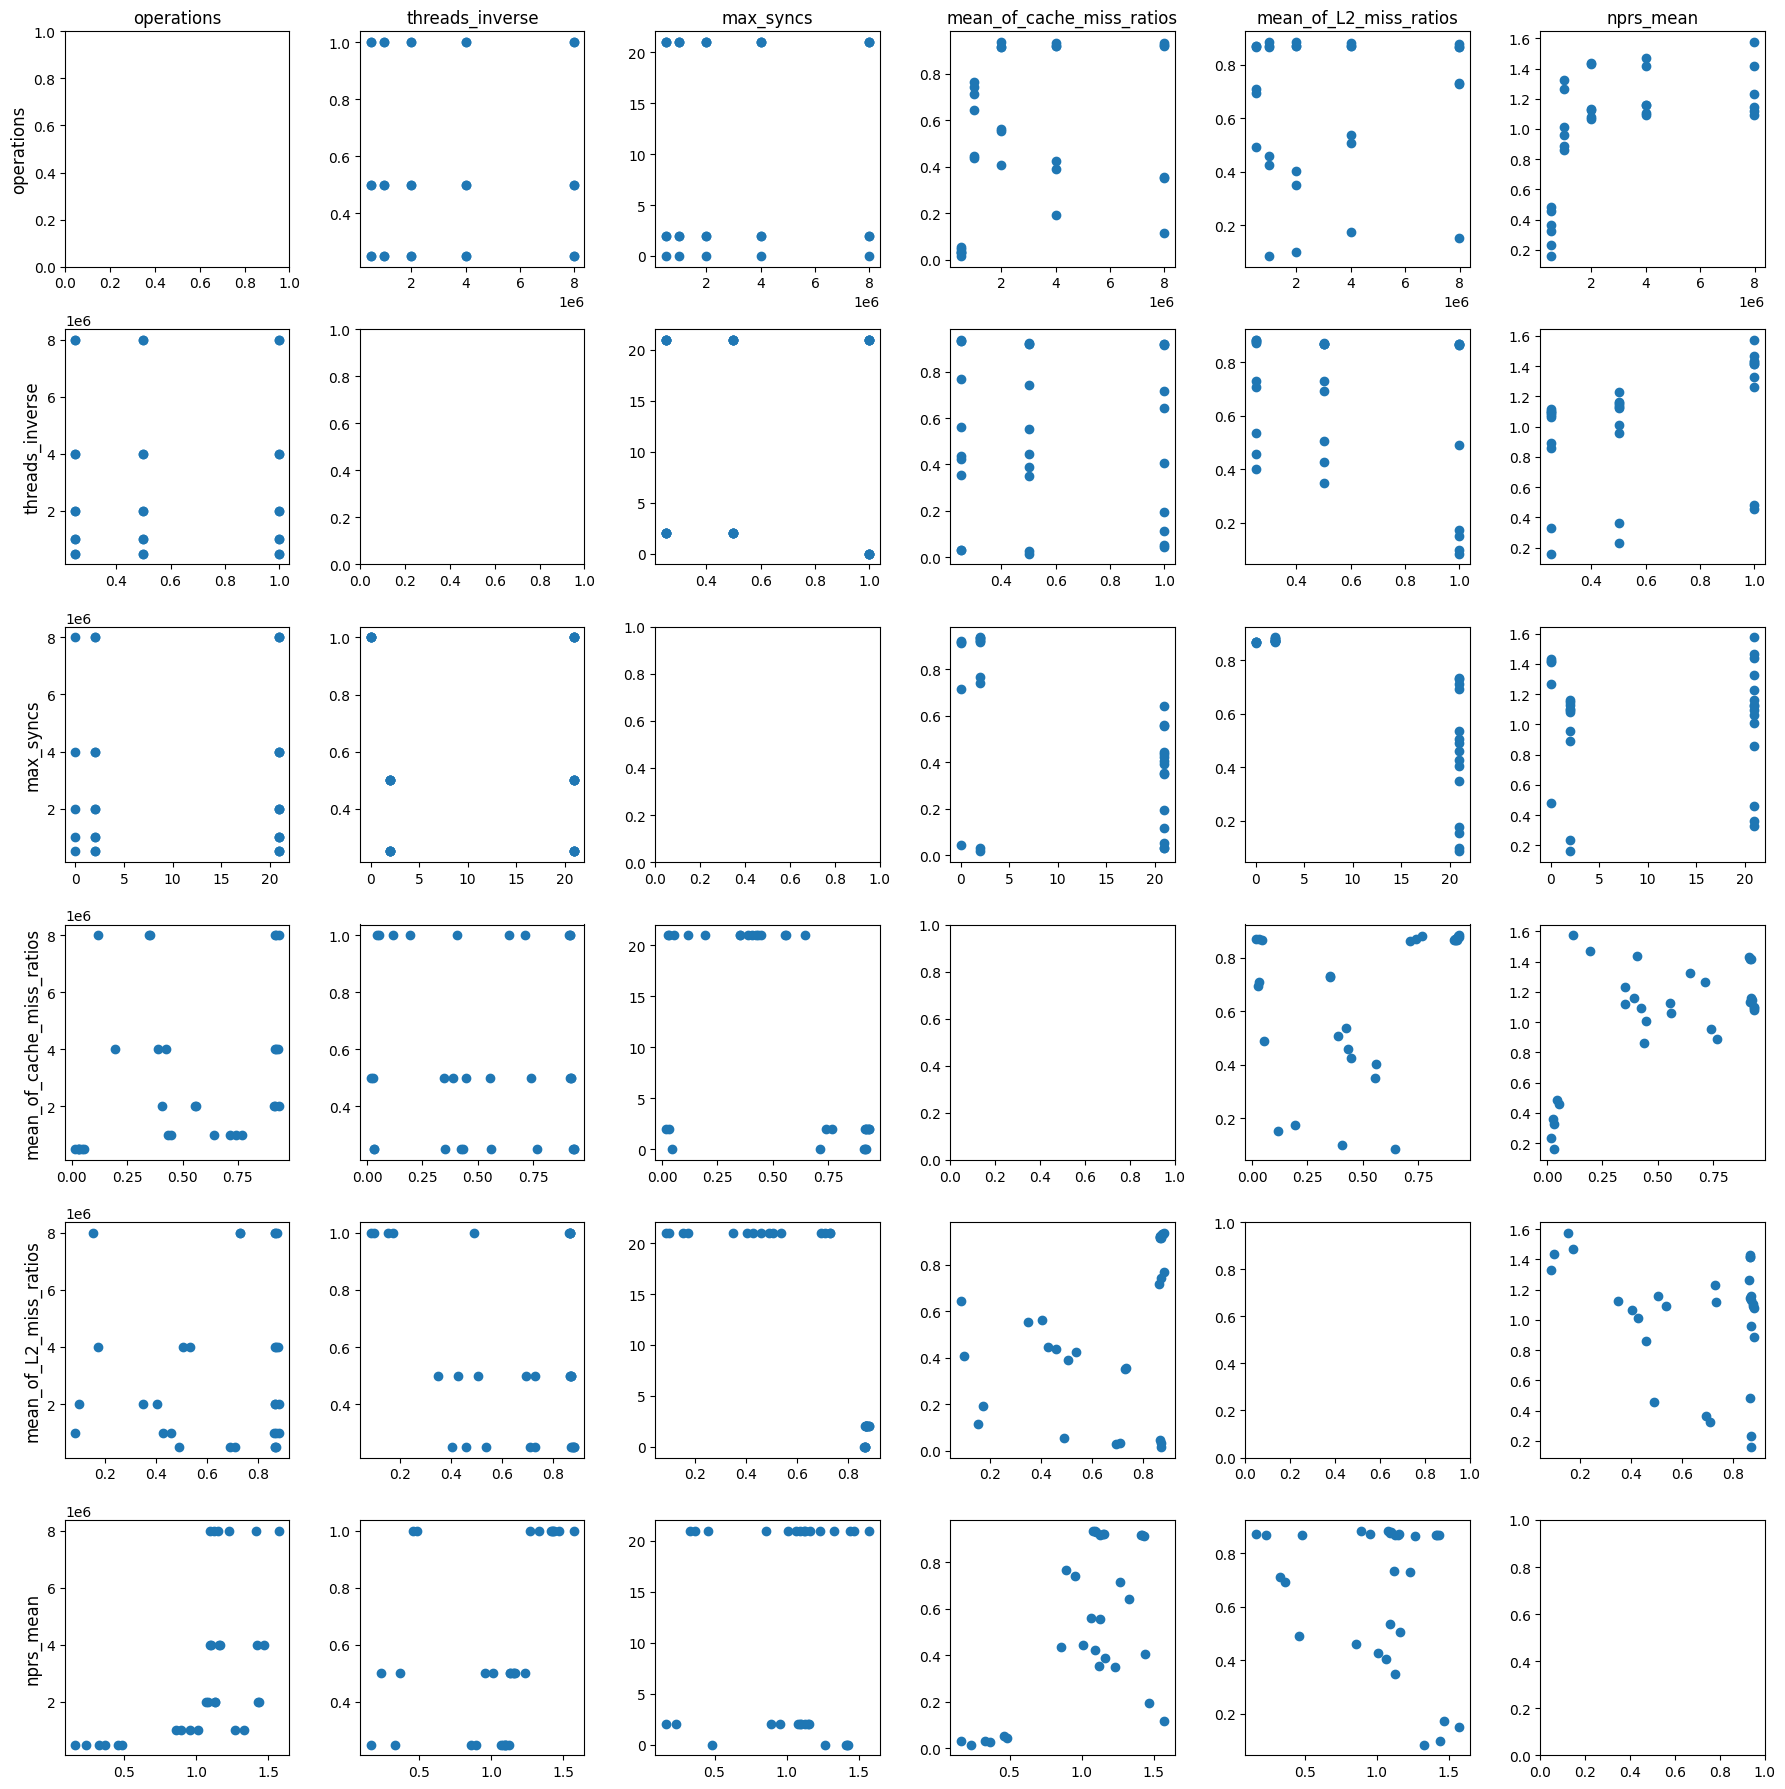

In [138]:
fig, axes = plt.subplots(len(keys), len(keys), figsize=(len(keys) * 3, len(keys) * 3))

for i in range(len(keys)):
    for j in range(len(keys)):
        if i == j:
            continue
        # i_ = i - 1 if i > j else i
        # j_ = j - 1 if j > i else j

        key1 = keys[i]
        key2 = keys[j]

        df.plot(x=key1, y=key2, style='o', ax=axes[i, j], xlabel=None, ylabel=None)
        axes[i, j].get_legend().remove()
        axes[i, j].set_ylabel(None)
        axes[i, j].set_xlabel(None)

for ax, col in zip(axes[0], keys):
    ax.set_title(col)

for ax, row in zip(axes[:,0], keys):
    ax.set_ylabel(row, size='large')

fig.tight_layout()
fig.show()

In [139]:
df.corr()

,operations,threads_inverse,max_syncs,mean_of_cache_miss_ratios,mean_of_L2_miss_ratios,nprs_mean
operations,1.000000e+00,4.565306e-17,5.546095e-17,0.285307,0.049901,0.552017
threads_inverse,4.565306e-17,1.000000e+00,-4.519477e-02,-0.060648,-0.310102,0.388458
max_syncs,5.546095e-17,-4.519477e-02,1.000000e+00,-0.554334,-0.810735,0.038940
mean_of_cache_miss_ratios,2.853072e-01,-6.064848e-02,-5.543335e-01,1.000000,0.376966,0.586214
mean_of_L2_miss_ratios,4.990095e-02,-3.101015e-01,-8.107353e-01,0.376966,1.000000,-0.313354
nprs_mean,5.520167e-01,3.884583e-01,3.894028e-02,0.586214,-0.313354,1.000000


In [140]:
model_smf = smf.ols(formula='nprs_mean ~ ' + ' + '.join(keys[:-1]), data=df).fit()
print(model_smf.summary())

                            OLS Regression Results                            
Dep. Variable:              nprs_mean   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     34.94
Date:                Sat, 18 May 2024   Prob (F-statistic):           2.93e-10
Time:                        16:38:42   Log-Likelihood:                 17.924
No. Observations:                  30   AIC:                            -23.85
Df Residuals:                      24   BIC:                            -15.44
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [141]:
X = df[keys[:-1]].to_numpy()
y = df[keys[-1]].to_numpy()

In [142]:
model_lr = LinearRegression()
model_lr.fit(X=X, y=y)

y_pred = model_lr.predict(X)

print('MPE:', np.mean(np.abs((y_pred - y) / y)))
print('MAE:', np.mean(np.abs(y_pred - y)))
print(model_lr.coef_, model_lr.intercept_)

MPE: 0.12040824658933724
MAE: 0.10249426831840489
[ 5.14625154e-08  3.82515361e-01  4.77569855e-03  8.18586347e-01
 -5.83553946e-01] 0.5388815303324523


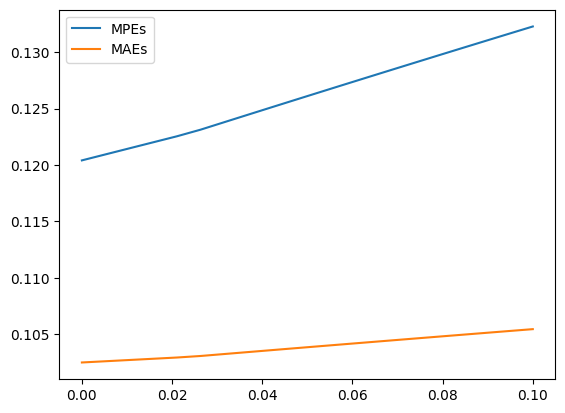

In [143]:
alphas = np.linspace(start=0, stop=0.1, num=20)
mpes = []
maes = []

for alpha in alphas:
    model_ridge = Ridge(alpha=alpha)
    model_ridge.fit(X=X, y=y)

    y_pred = model_ridge.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()


/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/shkiper/miniconda3/envs/pt_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e-01, tolerance: 4.402e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

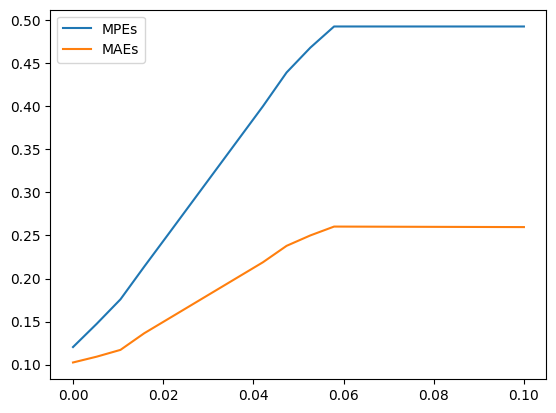

In [144]:
alphas = np.linspace(start=0, stop=0.1, num=20)
mpes = []
maes = []
for alpha in alphas:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X=X, y=y)

    y_pred = model_lasso.predict(X)

    mpes.append(np.mean(np.abs((y_pred - y) / y)))
    maes.append(np.mean(np.abs((y_pred - y))))

plt.plot(alphas, mpes, label='MPEs')
plt.plot(alphas, maes, label='MAEs')
plt.legend(loc="upper left")
plt.show()

In [145]:
mpes = []
maes = []

for _ in tqdm(range(10000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)

    model_lr_mlway = LinearRegression()
    model_lr_mlway.fit(X=X_train, y=y_train)

    y_pred = model_lr_mlway.predict(X_test)

    mpes.append(np.mean(np.abs((y_pred - y_test) / y_test)))
    maes.append(np.mean(np.abs((y_pred - y_test))))

print('Mean MPE:', np.mean(mpes))
print('Mean MAE:', np.mean(maes))

100%|██████████| 10000/10000 [00:08<00:00, 1111.29it/s]

Mean MPE: 0.17763655293226122
Mean MAE: 0.1432959700866504
